<h1 style="font-family:verdana;"> <center>📓  Audio Age  Capturing Notebook by: The BOIS 📓</center> </h1>
<p><center style="color:#008080; font-family:cursive;"></center></p>

***

# 1.Importing libraries 📚

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.fftpack import fft
import librosa
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import wave
import os
x = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    x.append(filenames)

import random
import torch
import soundfile as sf
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import copy
from tqdm import tqdm
from torchvision.transforms import InterpolationMode

import torchaudio
from pathlib import Path
import torch.nn.functional as F



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 # 2. Data Pre-processing 🏋️‍♂️ 

In [2]:
os.makedirs("wav")
os.makedirs("pics")

In [3]:
x = x[4]

In [4]:
traindf = pd.read_csv("/kaggle/input/ieeenu-cis-senior-members-nuaih-age-capturing-2/Age_Through_Speech/Age_Through_Speech/train.csv")
testdf = pd.read_csv("/kaggle/input/ieeenu-cis-senior-members-nuaih-age-capturing-2/Age_Through_Speech/Age_Through_Speech/test.csv")

In [5]:
traindf = traindf.query("Subject != 4289 and Subject != 4604")

In [6]:
traindf.reset_index(inplace=True)
traindf.drop('index',axis=1)

,Subject,Age
0,4001,19
1,4002,23
2,4003,18
3,4004,23
4,4005,17
...,...,...
362,4689,17
363,4690,16
364,4694,18
365,4695,23


In [7]:
print(traindf.shape,list(traindf.columns))
print(testdf.shape,list(testdf.columns))

(367, 3) ['index', 'Subject', 'Age']
(157, 2) ['Subject', 'Age']


In [8]:
fpath = "/kaggle/input/ieeenu-cis-senior-members-nuaih-age-capturing-2/Age_Through_Speech/Age_Through_Speech/one_and_multiple/"

# 2.1 Creating and Improving The Dataset ⇡

In [9]:
def sample_length(log_mel_spec):
    return log_mel_spec.shape[-1]


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels,path, transforms=None, normalize=False):
        assert len(filenames) == len(labels), f'Inconsistent length of filenames and labels.'

        self.filenames = filenames
        self.labels = labels
        self.transforms = transforms
        self.normalize = normalize
        self.path = path

        # Calculate length of clip this dataset will make
        self.unit_length = 38

        # Test with first file
        assert self[0][0].shape[-1] == self.unit_length, f'Check your files, failed to load {filenames[0]}'

        # Show basic info.
        print(f'Dataset will yield log-mel spectrogram {len(self)} data samples in shape [1, {128}, {self.unit_length}]')

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        assert 0 <= index and index < len(self)
        
        log_mel_spec = np.load(self.path+str(self.filenames[index])+".npy")
#         log_mel_spec = np.array(log_mel_spec)
        
        # normalize - instance based
        if self.normalize:
            _m, _s = log_mel_spec.mean(),  log_mel_spec.std() + np.finfo(np.float64).eps
            log_mel_spec = (log_mel_spec - _m) / _s
#             print(log_mel_spec)
#             print(_m)

        # Padding if sample is shorter than expected - both head & tail are filled with 0s
        pad_size = self.unit_length - sample_length(log_mel_spec)
        if pad_size > 0:
            offset = pad_size // 2
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, 0), (offset, pad_size - offset)), 'constant')

        # Random crop
        crop_size = sample_length(log_mel_spec) - self.unit_length
        if crop_size > 0:
            start = np.random.randint(0, crop_size)
            log_mel_spec = log_mel_spec[..., start:start + self.unit_length]

        # Apply augmentations
        log_mel_spec = torch.Tensor(log_mel_spec)
        if self.transforms is not None:
            log_mel_spec = self.transforms(log_mel_spec)

        return log_mel_spec, self.labels[index]

In [10]:
def concat(df):    
    count = 0
    for i in df["Subject"]:
        count+=1

        subject = str(i)
        outfile = "/kaggle/working/wav/"+subject +".wav"
        infiles = []
        if subject in ["4289","4604"]:
            print("stoppppppppppppppppppppppppp")

        for file in x:
            if subject in file:
                infiles.append(file)

        d = [] 
        for infile in infiles:
            w = wave.open(fpath+infile, 'rb')
            d.append( [w.getparams(), w.readframes(w.getnframes())] )
            w.close()
        output = wave.open(outfile, 'wb')
        output.setparams(d[0][0])
        for i in range(len(d)):
            output.writeframes(d[i][1])
        output.close()

In [11]:
concat(traindf)
concat(testdf)

# 2.3 Creating Spectogram 🔊
<center>
<img src="https://media.giphy.com/media/pv9vqIFuUD44TdnR73/giphy.gif" width=300>
</center>

In [12]:
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000, n_fft = 2048, f_min = 0, f_max= 20000)

def spectogram (df):
    count = 0
    WORK = Path('/kaggle/working/pics/')
    for i in df["Subject"]:
        count+=1
        subject = str(i)
        filename = '/kaggle/working/wav/' + subject +".wav"
        b = WORK/(subject+".wav")

        y, sr = librosa.load(filename, sr=48000)

        # Create mel-spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=22000, hop_length=256)

        # Convert power spectrogram to dB scale (log scale)
        S_dB = librosa.power_to_db(S, ref=np.max)



        x = b.name.replace('.wav', '.npy')
        x =  WORK/x
        # Save as PNG file
        np.save(x, S_dB)
#         plt.close()


In [13]:
spectogram(traindf)
spectogram(testdf)

# 2.4 Loading Dataset ↻
* Batch size
* data Loaders


In [14]:
data_path = "/kaggle/working/pics/"
batch_size = 8
test_batch = 64

trans = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
])

train_dataset = MyDataset(traindf["Subject"],traindf["Age"],data_path, normalize=True)
# trainloader = data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle = True,drop_last=False,num_workers = 2)
testset = MyDataset(testdf["Subject"],testdf["Age"],data_path, normalize=True)
# testloader = data.DataLoader(dataset=testset,batch_size=batch_size,shuffle = False,drop_last=False,num_workers = 2)

# croset =  MyDataset(crossdf["Subject"],crossdf["Age"],data_path)
# crossloader = data.DataLoader(dataset=croset,batch_size=batch_size,shuffle = False,drop_last=False,num_workers = 2)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
trainset, valset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=test_batch,
                                         shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch,
                                         shuffle=False, num_workers=2)

image_datasets = {'train':trainset,'val':valset}

dataloaders_dict = {'train':trainloader,'val':valloader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset will yield log-mel spectrogram 367 data samples in shape [1, 128, 38]
Dataset will yield log-mel spectrogram 157 data samples in shape [1, 128, 38]


# 3. Model Creation/Defintion 🧩🛠️ <a class='anchor' id='top'></a>
## (All Models used are based on Resnet) 
1. [Custom Model (Boody)](#Boody)
2. [Custom Model (Nour)](#Nour)
3. [Cutome Model (Multiple Sources)](#Source)

# 3.1 Custom Model(Boody💪) <a class='anchor' id='Boody'></a>

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1):
        super(ResNet, self).__init__()
        self.inplanes = 1
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 38, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(38),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(63488, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
        x = torch.unsqueeze(x, dim=1)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# 3.2 Custom Model(Nour💡)<a class='anchor' id='Nour'></a>

In [17]:
class TransitionLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer,self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
class SemiTrans(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(SemiTrans,self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
import torch.nn as nn

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm2d(in_channels + i*growth_rate),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels + i*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
            )
            self.layers.append(layer)

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, dim=1))
            features.append(new_features)
        return torch.cat(features, dim=1)


In [18]:
class FunNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, 3, 1, 1, bias=False)
        
        self.d1 = DenseBlock(16, 8, 6)
        self.st1 = SemiTrans(64, 32)
        
        self.d2 = DenseBlock(32, 8, 4)
        self.t1 = TransitionLayer(64, 32)
        
        self.d3 = DenseBlock(32, 8, 4)
        self.d4 = DenseBlock(64, 32, 6)
        self.t2 = TransitionLayer(256, 128)
        
        self.d5 = DenseBlock(128, 32, 4)
        self.st2 = SemiTrans(256, 128)
        self.d6 = DenseBlock(128, 64, 2)
        
        self.av = nn.AvgPool2d(8)
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.unsqueeze(x,dim=1)
        x = self.conv(x)
        x = self.d1(x)
        x = self.st1(x)
        x = self.d2(x)
        x = self.t1(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.t2(x)
        x = self.d5(x)
        x = self.st2(x)
        x = self.d6(x)

        x = self.av(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
#         x = F.softmax(x, dim=1)
        return x

# 3.3 Custom Model(Multiple Sources) <a class='anchor' id='Source'></a>

In [19]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 38, 3, 1)
        self.conv2 = nn.Conv2d(38, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.pooling = nn.AdaptiveAvgPool2d((8, 8)) # extended
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.pooling(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# 4. Defining the training Fucntion 🚆

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 10000000
    train_acc_history = []
    #hl, = plt.plot([], [])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 labels= labels.sub(labels,1)
                inputs = inputs.float()
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels= labels.unsqueeze(1)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
#                     print(outputs)
#                     print(labels)
                    loss = criterion(outputs, labels)
#                     print(loss)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_acc:
                best_acc = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(float(epoch_loss))
            else:
                train_acc_history.append(float(epoch_loss))

        print()
        #update_line(hl,train_acc_history,val_acc_history)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,train_acc_history

# 4.1 Defining the Plot Function 📈

In [21]:
def plot(train_acc,test_acc): # plotting the line 1 points
    plt.plot([i+1 for i in range(len(train_acc))], train_acc, label = "Train")
    # plotting the line 2 points
    plt.plot([i+1 for i in range(len(test_acc))], test_acc, label = "Val")

    # naming the x axis
    plt.xlabel('epoch')
    # naming the y axis
    plt.ylabel('MSE')
    # giving a title to my graph
    plt.title('Train Val MSE')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

In [22]:
num_epochs = 60

# 4.2 Training the models and Ploting The results🥊
* Training and Ploting for each model

In [23]:
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 8])
model_resnet = model_resnet.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model_resnet, val_hist, train_hist = train_model(model_resnet, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/59
----------
train Loss: 269.3197 Acc: 0.0000
val Loss: 62.9481 Acc: 0.0000

Epoch 1/59
----------
train Loss: 69.5215 Acc: 0.0000
val Loss: 23.7908 Acc: 0.0000

Epoch 2/59
----------
train Loss: 52.7205 Acc: 0.0000
val Loss: 58.4563 Acc: 0.0000

Epoch 3/59
----------
train Loss: 65.4851 Acc: 0.0000
val Loss: 21.8797 Acc: 0.0000

Epoch 4/59
----------
train Loss: 51.6188 Acc: 0.0000
val Loss: 21.7872 Acc: 0.0000

Epoch 5/59
----------
train Loss: 50.0489 Acc: 0.0000
val Loss: 37.5909 Acc: 0.0000

Epoch 6/59
----------
train Loss: 60.6553 Acc: 0.0000
val Loss: 55.3843 Acc: 0.0000

Epoch 7/59
----------
train Loss: 56.8772 Acc: 0.0000
val Loss: 34.1257 Acc: 0.0000

Epoch 8/59
----------
train Loss: 50.7234 Acc: 0.0000
val Loss: 24.1307 Acc: 0.0000

Epoch 9/59
----------
train Loss: 77.2034 Acc: 0.0000
val Loss: 43.6352 Acc: 0.0000

Epoch 10/59
----------
train Loss: 50.0154 Acc: 0.0000
val Loss: 24.7153 Acc: 0.0000

Epoch 11/59
----------
train Loss: 47.5930 Acc: 0.0000
val Loss

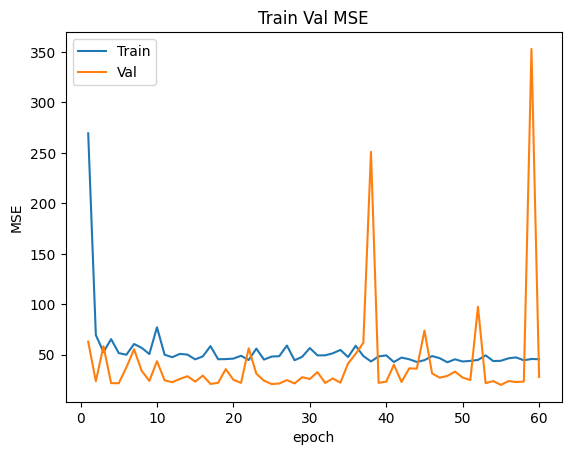

In [24]:
train = []
val  = []
for i in train_hist:
    train.append(float(i))
for i in val_hist:
    val.append(float(i))

plot(train,val)

In [25]:
model_fun = FunNET()
model_fun = model_fun.to(device)
criterion = nn.MSELoss()
optimizer_fun = optim.Adam(model_fun.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_fun, T_max=num_epochs)
model_fun, val_hist, train_hist = train_model(model_fun, dataloaders_dict, criterion, optimizer_fun, num_epochs=num_epochs)

Epoch 0/59
----------
train Loss: 84.3594 Acc: 0.0000
val Loss: 30.0333 Acc: 0.0000

Epoch 1/59
----------
train Loss: 45.7689 Acc: 0.0000
val Loss: 24.2001 Acc: 0.0000

Epoch 2/59
----------
train Loss: 45.4708 Acc: 0.0000
val Loss: 23.4197 Acc: 0.0000

Epoch 3/59
----------
train Loss: 48.3200 Acc: 0.0000
val Loss: 24.7419 Acc: 0.0000

Epoch 4/59
----------
train Loss: 45.5314 Acc: 0.0000
val Loss: 23.4013 Acc: 0.0000

Epoch 5/59
----------
train Loss: 44.8528 Acc: 0.0000
val Loss: 23.8648 Acc: 0.0000

Epoch 6/59
----------
train Loss: 56.9707 Acc: 0.0000
val Loss: 39.9033 Acc: 0.0000

Epoch 7/59
----------
train Loss: 46.9262 Acc: 0.0000
val Loss: 25.0126 Acc: 0.0000

Epoch 8/59
----------
train Loss: 44.8546 Acc: 0.0000
val Loss: 23.0939 Acc: 0.0000

Epoch 9/59
----------
train Loss: 48.6510 Acc: 0.0000
val Loss: 28.1595 Acc: 0.0000

Epoch 10/59
----------
train Loss: 44.9919 Acc: 0.0000
val Loss: 21.7134 Acc: 0.0000

Epoch 11/59
----------
train Loss: 43.3485 Acc: 0.0000
val Loss:

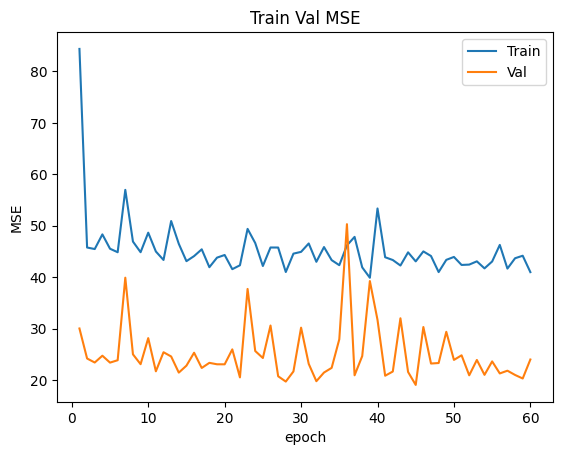

In [26]:
train = []
val  = []
for i in train_hist:
    train.append(float(i))
for i in val_hist:
    val.append(float(i))

plot(train,val)

In [27]:
model_net = Net(1)
model_net = model_fun.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_net.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model_net, val_hist, train_hist = train_model(model_net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/59
----------
train Loss: 43.6550 Acc: 0.0000
val Loss: 21.5664 Acc: 0.0000

Epoch 1/59
----------
train Loss: 42.6678 Acc: 0.0000
val Loss: 20.4653 Acc: 0.0000

Epoch 2/59
----------
train Loss: 43.7097 Acc: 0.0000
val Loss: 25.0743 Acc: 0.0000

Epoch 3/59
----------
train Loss: 45.3663 Acc: 0.0000
val Loss: 33.2476 Acc: 0.0000

Epoch 4/59
----------
train Loss: 42.5219 Acc: 0.0000
val Loss: 21.6670 Acc: 0.0000

Epoch 5/59
----------
train Loss: 40.9648 Acc: 0.0000
val Loss: 22.8390 Acc: 0.0000

Epoch 6/59
----------
train Loss: 44.2372 Acc: 0.0000
val Loss: 22.6567 Acc: 0.0000

Epoch 7/59
----------
train Loss: 43.8438 Acc: 0.0000
val Loss: 21.2947 Acc: 0.0000

Epoch 8/59
----------
train Loss: 41.6179 Acc: 0.0000
val Loss: 20.0984 Acc: 0.0000

Epoch 9/59
----------
train Loss: 44.9047 Acc: 0.0000
val Loss: 23.0368 Acc: 0.0000

Epoch 10/59
----------
train Loss: 41.6579 Acc: 0.0000
val Loss: 22.4198 Acc: 0.0000

Epoch 11/59
----------
train Loss: 40.0990 Acc: 0.0000
val Loss:

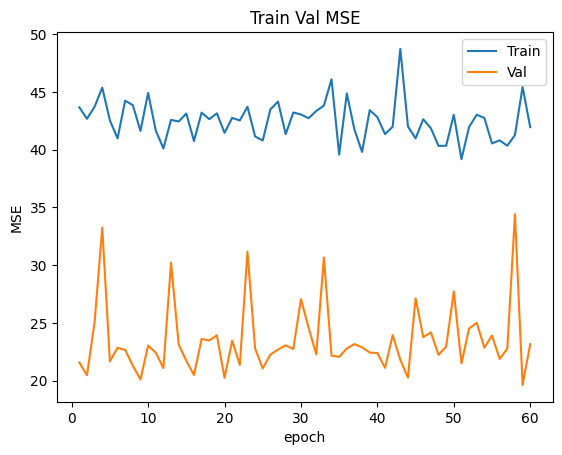

In [28]:
train = []
val  = []
for i in train_hist:
    train.append(float(i))
for i in val_hist:
    val.append(float(i))

plot(train,val)

# 5. Models Ensembling👷‍♂️

In [29]:
preds_resnet = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.float()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_resnet(images)
        preds_resnet.extend(outputs)

In [30]:
preds_fun = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.float()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_fun(images)
        preds_fun.extend(outputs)

In [31]:
preds_net = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.float()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_net(images)
        preds_net.extend(outputs)

In [32]:
preds = []
for i in range(len(preds_resnet)):
    preds_resnet[i] = float(preds_resnet[i])
    preds_fun[i] = float(preds_fun[i])
    preds_net[i] = float(preds_net[i])
    preds.append((preds_resnet[i]+preds_fun[i]+preds_net[i])/3)
    

# 5.1 Calculating the inference time⏲

In [33]:
infloader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=False,num_workers = 2)
image,label = next(iter(infloader))
start = time.time()
outputs_resnet = model_resnet(image.float().to(device))
outputs_fun = model_fun(image.float().to(device))
outputs_net = model_net(image.float().to(device))
outputs = (outputs_resnet+outputs_fun+outputs_net)/3
end = time.time()
inf_time = end-start
inf_time

0.047861337661743164

# 5.2 Creating the Submission File 💾

In [34]:
testdf['Age'] = preds

In [35]:
testdf.head()

,Subject,Age
0,4697,21.399366
1,4699,22.340612
2,4702,19.809750
3,4706,20.185237
4,4708,20.351405


In [36]:
testdf.to_csv('submn.csv', index=False)